# Table of Contents
* [Loading data](#Loading-data)
* [Object counts](#Object-counts)
* [Image brightness](#Image-brightness)
* [Look at v2 matlab files](#Look-at-v2-matlab-files)
* [Build dataset scaffolding](#Build-dataset-scaffolding)
	* [explore](#explore)
	* [code](#code)
	* [run](#run)
* [hide](#hide)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [3]:
import glob
import os
import json
import re
import PIL.Image as Image
import PIL.ImageStat as ImageStat
from multiprocessing import Pool
from tqdm import tqdm

# Loading data

In [4]:
all_ds_files = glob.glob('./SUNRGBD/**', recursive=True)
len(all_ds_files)

image_names = [iname for iname in all_ds_files if 'image/' in iname]
img_numbs = sorted([i.split('/')[-1].split('.jpg')[0] for i in image_names])
len(image_names)

d2_anno_names = [iname for iname in all_ds_files if 'annotation2Dfinal/' in iname and not 'json_' in iname]
d3_anno_names = [iname for iname in all_ds_files if 'annotation3Dfinal/' in iname and not 'json_' in iname]
d2_3_anno_names = [iname for iname in all_ds_files if 'annotation2D3D/' in iname and not 'json_' in iname]
anno_types = {
    '2D': d2_anno_names,
    '3D': d3_anno_names,
    '2D3D': d2_3_anno_names
}

In [158]:
img_pattern = re.compile('.*(img_[0-9]+|NYU[0-9]+|[0-9]+_[0-9]+|[0-9]+-[0-9]+).*')

sun_rgb_anno = defaultdict(lambda: defaultdict(dict))
dedupe_count = 0
for ann_type, anno_names in anno_types.items():
    for ann_fn in tqdm(anno_names):
        img_dir = ann_fn.split('/')[-3]
        try:
            img_n = re.findall(img_pattern, ann_fn)[0]
        except IndexError as e:
            pass
        with open(ann_fn, 'r') as f:
            try:
                img_annotation = json.load(f)
            except json.JSONDecodeError as e:
                pass
        sun_rgb_anno[img_dir][ann_type] = img_annotation
        dedupe_count += 1

100%|██████████| 10331/10331 [00:03<00:00, 2824.93it/s]


# Object counts

In [201]:
sun_annos_2d = {img: anno['2D'] for img, anno in sun_rgb_anno.items()}

In [202]:
img_objects= {}
for image_anno in sun_annos_2d.values():
    if image_anno:
        objects = [obj['name'] for obj in image_anno['objects'] if obj]
        img_objects[image_anno['name']] = len(objects)

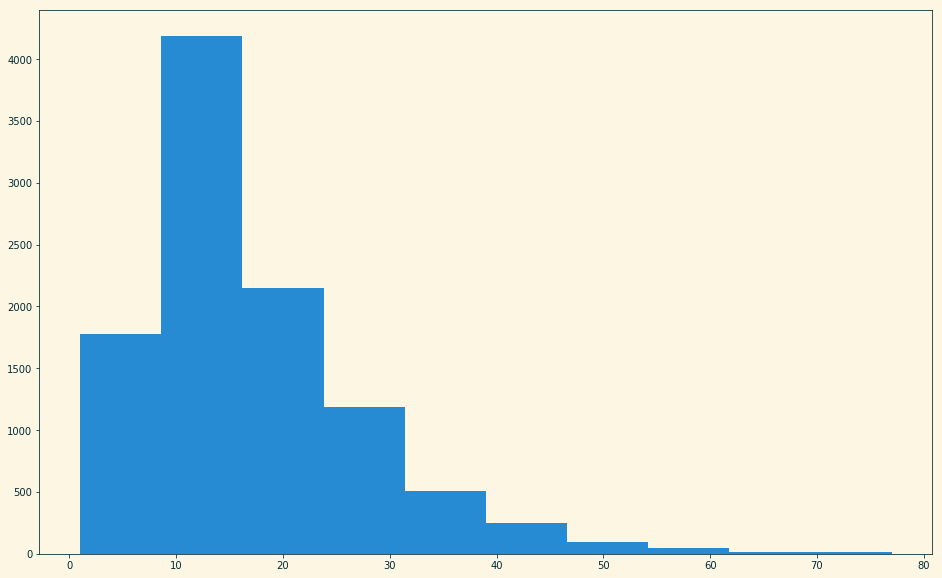

In [203]:
obj_freq_series = pd.Series(list(img_objects.values()))
_ = obj_freq_series[obj_freq_series < 80].hist()

In [204]:
object_counts = Counter()
for image_anno in sun_annos_2d.values():
    if image_anno:
        objects = [obj['name'].lower() for obj in image_anno['objects'] if obj]
        object_counts.update(objects)

In [205]:
sum(object_counts.values())

176167

In [206]:
freq_series = pd.Series(list(object_counts.values()))

In [207]:
len(freq_series)

11287

In [208]:
len(freq_series[freq_series > 5])

1465

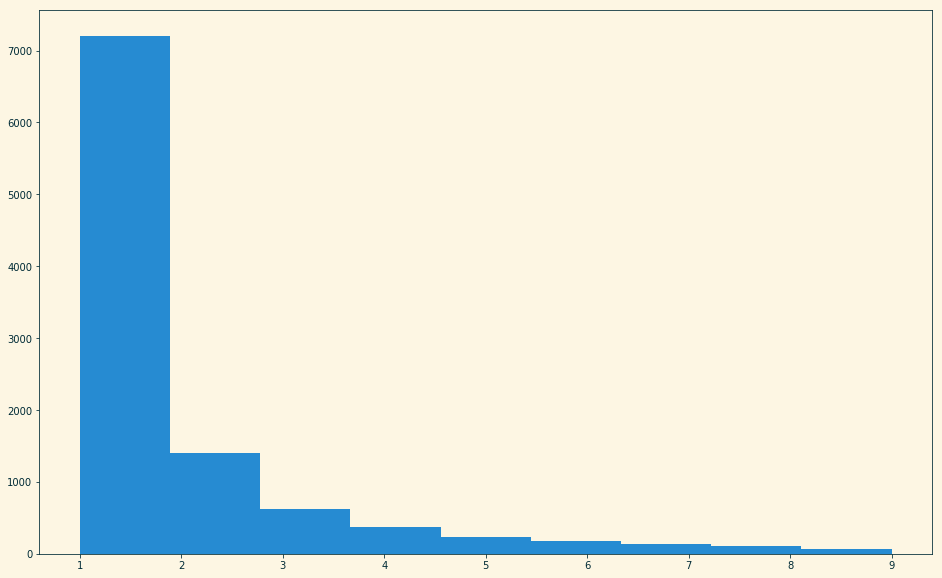

In [209]:
_ = freq_series[freq_series < 10].hist(bins=9)

In [210]:
sum(freq_series)

176167

In [28]:
object_freqs = object_counts.most_common()

In [29]:
len(object_freqs)

1246

In [30]:
object_counts['window']

44

In [31]:
filtered_objs = [ob for ob in object_freqs if ob[1] > 5]
class_freq_series = pd.Series([ob[1] for ob in  filtered_objs])

In [32]:
total_obj_instanc_count = sum(class_freq_series)

In [33]:
total_obj_instanc_count

77982

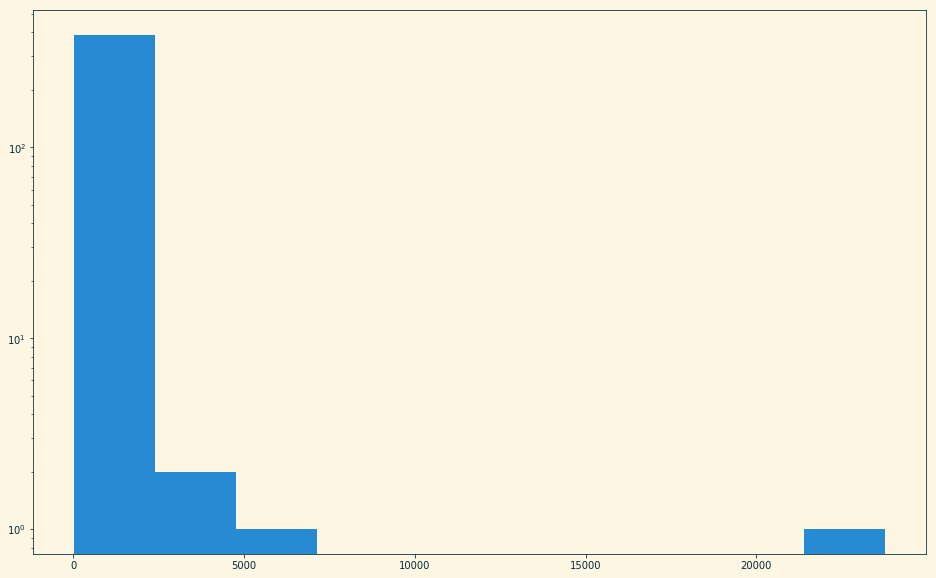

In [34]:
_ = class_freq_series.hist(log=True)

In [35]:
len(filtered_objs)

391

In [36]:
sum([ob[1] for ob in filtered_objs[100:]])

5417

In [37]:
[ob for ob in object_freqs if 'garbage' in ob[0].lower()]

[('garbage_bin', 1269),
 ('garbagebin:occluded', 8),
 ('garbagebin:truncated', 7),
 ('garbage-bin', 6),
 ('garbagebag', 2)]

# Image brightness

In [216]:
def mean_pixel_level(img_file):
    img = Image.open(img_file).convert('L')
    img_stats = ImageStat.Stat(img)
    return img_stats.mean[0]

def compute_img_brightnesses(image_files):
    img_brightnesses = {}
    for img in image_files:
#         img_brightnesses[img.split('/')[-1]] = mean_pixel_level(img)
        img_brightnesses[img] = mean_pixel_level(img)
    return img_brightnesses

In [266]:
def img_height(img_file):
    img = Image.open(img_file)
    return img.height

def compute_img_heights(image_files):
    img_brightnesses = {}
    for img in image_files:
        img_brightnesses[img.split('/')[-3]] = img_height(img)
#         img_brightnesses[img] = mean_pixel_level(img)
    return img_brightnesses

In [263]:
%%time
n_processes = 8
pool = Pool(processes=n_processes)

img_split = np.array_split(image_names, n_processes)
pool_results = pool.map(compute_img_brightnesses, img_split)
img_brightnesses = {}
for res in pool_results:
    img_brightnesses.update(res)

Process ForkPoolWorker-45:


KeyboardInterrupt: 

Process ForkPoolWorker-47:
Process ForkPoolWorker-48:
Process ForkPoolWorker-44:
Process ForkPoolWorker-42:
Traceback (most recent call last):
Process ForkPoolWorker-43:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process ForkPoolWorker-41:
Traceback (most recent call last):
Process ForkPoolWorker-46:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.0/Frameworks/Pyt

In [267]:
%%time
n_processes = 8
pool = Pool(processes=n_processes)

img_split = np.array_split(image_names, n_processes)
pool_results = pool.map(compute_img_heights, img_split)
img_heights = {}
for res in pool_results:
    img_heights.update(res)

CPU times: user 22.4 ms, sys: 115 ms, total: 137 ms
Wall time: 347 ms


In [259]:
import pickle

In [269]:
with open('image_heights.pkl', 'wb') as f:
    pickle.dump(img_heights, f)

In [268]:
list(img_heights.items())[0]

('img_0063', 427)

In [252]:
list(img_brightnesses.items())[0]

('./SUNRGBD/kv1/b3dodata/img_0063/image/img_0063.jpg', 116.29581668733067)

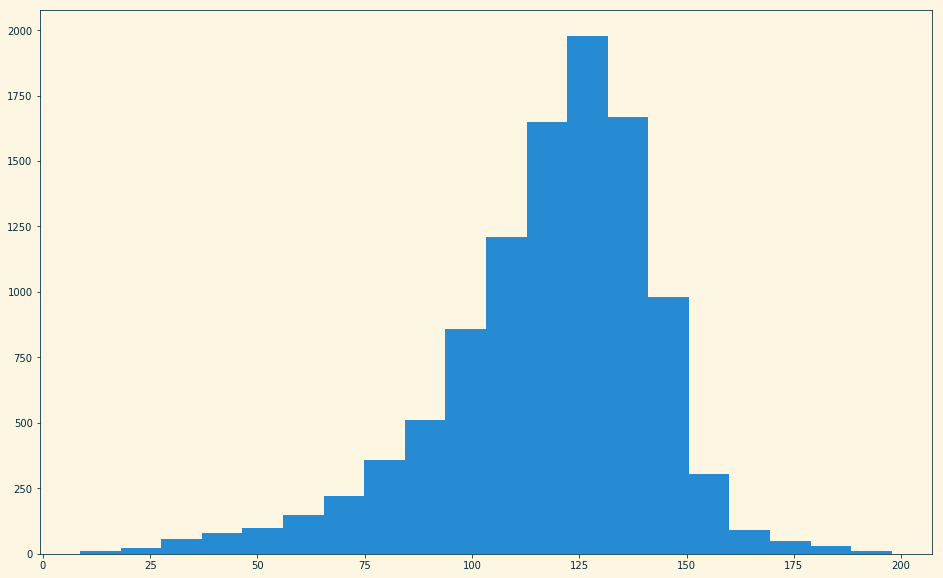

In [218]:
_ = pd.Series(list(img_brightnesses.values())).hist(bins=20)

In [221]:
dim_images = {k: v for k, v in img_brightnesses.items() if v > 50}

In [245]:
random_img = np.random.choice(list(dim_images.keys()), 1).item()
sampled_image = Image.open(random_img)

In [246]:
sampled_image.size

(561, 427)

In [224]:
# rare_objects = [ob[0] for ob in object_freqs if ob[1] < 5]
# common_objects = [ob[0] for ob in object_freqs if ob[1] > 5]

In [44]:
object_list = [ob[0] for ob in object_freqs if ob[1] > 5]

In [104]:
len(object_list)

NameError: name 'object_list' is not defined

In [103]:
# deduped_objs = set([ob.lower().split(':')[0] for ob in object_list])
# len(deduped_objs)

# Look at v2 matlab files

In [29]:
updated_2d_bbs = loadmat('./SUNRGBDMeta2DBB_v2.mat')['SUNRGBDMeta2DBB']
updated_3d_bbs = loadmat('./SUNRGBDMeta3DBB_v2.mat')['SUNRGBDMeta']

In [57]:
v1_meta = loadmat('SUNRGBDtoolbox/Metadata/SUNRGBDMeta.mat')['SUNRGBDMeta']

In [102]:
# v1_meta.dtype.names

In [100]:
# v1_meta['sequenceName'][0][0]

In [99]:
# v1_meta['groundtruth3DBB'][0][0]

In [58]:
comp_k = [k for k in sun_rgb_anno.keys() if 'NYU0352' in k][0]

In [137]:
updated_2d_bbs[0].dtype

dtype([('sequenceName', 'O'), ('groundtruth2DBB', 'O'), ('depthpath', 'O'), ('rgbpath', 'O'), ('depthname', 'O'), ('rgbname', 'O'), ('sensorType', 'O')])

In [139]:
updated_2d_bbs.dtype

dtype([('sequenceName', 'O'), ('groundtruth2DBB', 'O'), ('depthpath', 'O'), ('rgbpath', 'O'), ('depthname', 'O'), ('rgbname', 'O'), ('sensorType', 'O')])

In [144]:
t3dbb = updated_2d_bbs[0]

In [145]:
t3dbb['sequenceName']

array([ array([ 'SUNRGBD/kv2/kinect2data/000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize'], 
      dtype='<U81')], dtype=object)

In [151]:
updated_2d_bbs[0]

array([ (array([ 'SUNRGBD/kv2/kinect2data/000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize'], 
      dtype='<U81'), array([[ (array([[0]], dtype=uint8), array([[328, 152, 346, 320]], dtype=uint16), array(['bed'], 
      dtype='<U3'), array([[1]], dtype=uint8)),
        (array([[1]], dtype=uint8), array([[ 572.54180602,  275.63545151,   98.37792642,   53.17725753]]), array(['night_stand'], 
      dtype='<U11'), array([[1]], dtype=uint8)),
        (array([[2]], dtype=uint8), array([[ 332.35785953,  318.17725753,  316.40468227,  209.1638796 ]]), array(['ottoman'], 
      dtype='<U7'), array([[1]], dtype=uint8)),
        (array([[3]], dtype=uint8), array([[ 157.75919732,   10.63545151,  156.8729097 ,  362.4916388 ]]), array(['dresser_mirror'], 
      dtype='<U14'), array([[1]], dtype=uint8)),
        (array([[4]], dtype=uint8), array([[  1,   1, 221, 529]], dtype=uint16), array(['dresser'], 
      dtype='<U7'), array([[1]], dtype=uint8)),
        (array([[5]], dtype=uint8), array(

In [156]:
updated_2d_bbs['sequenceName'][0]

array([ array([ 'SUNRGBD/kv2/kinect2data/000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize'], 
      dtype='<U81')], dtype=object)

In [140]:
# comp_anno_1 = sun_ds_scaf['000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize']

In [212]:
# for field in t3dbb['groundtruth3DBB_tight'][0].dtype.names:
    print(field)
    print(t3dbb['groundtruth3DBB_tight'][0][field])
    print()

IndentationError: unexpected indent (<ipython-input-212-4b94c858c719>, line 2)

# Build dataset scaffolding

## explore

In [214]:
import PIL.Image as Image
import cv2
from SUNRGBDtoolbox_python.SUNRGBD import readFrame
import random as rand

In [247]:
random_img = np.random.choice(list(dim_images.keys()), 1).item()

rand_img_dir = random_img.split('image/')[0]
print(rand_img_dir)
frameData = readFrame(rand_img_dir, True )

imgRGBWithAnnotations = np.array(frameData.imgRGB, copy=True);

for i in range(0, len(frameData.annotation2D)):
    color = [rand.randint(0,255), rand.randint(0,255), rand.randint(0,255)]
    cv2.fillPoly(imgRGBWithAnnotations, [frameData.annotation2D[i]], color)

for i in range(0, len(frameData.annotation2D)):	
    data = frameData.annotation2D[i];
    centroid = np.mean(data,axis=0)
    cv2.putText(imgRGBWithAnnotations, frameData.labels2D[i], (int(centroid[0]), int(centroid[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.7, [0,0,0],2)

./SUNRGBD/realsense/lg/2014_10_24-13_27_43-1311000073/


In [253]:
test_image = Image.fromarray(frameData.imgRGB)

In [254]:
test_image.height

531

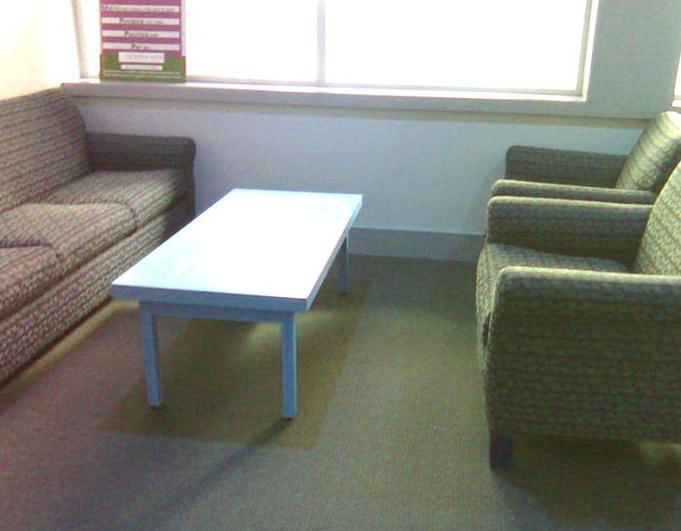

In [248]:
Image.fromarray(frameData.imgRGB)

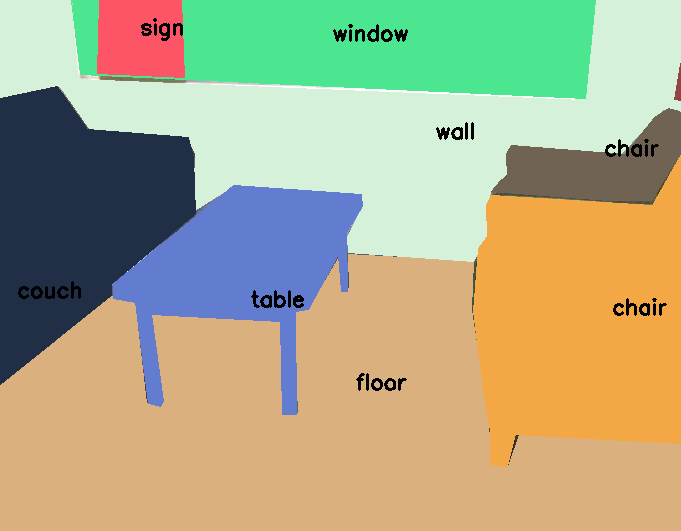

In [249]:
Image.fromarray(imgRGBWithAnnotations)

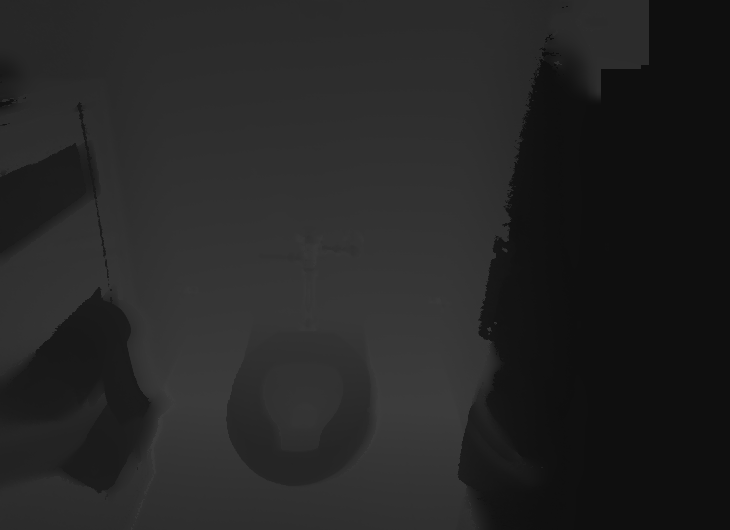

In [69]:
Image.fromarray(frameData.imgD)

plan for assembling this:

Could be a dict of image: to properties, including objects

or just objectIDs to objects, with image as property

each object needs:

id

2D poly, bbox

3D poly, depth, bounding cube

properties



In [70]:
print(sorted([ob2.item() for ob2 in [ob['classname'][0] for ob in  updated_2d_bbs['SUNRGBDMeta2DBB'].T[updated_2d_bbs['SUNRGBDMeta2DBB'].T['sequenceName'] == rand_img_dir[2:-1]]['groundtruth2DBB']][0].tolist()]))

['toilet']


In [71]:
print(sorted([ob2.item() for ob2 in [ob['objid'][0] for ob in  updated_2d_bbs['SUNRGBDMeta2DBB'].T[updated_2d_bbs['SUNRGBDMeta2DBB'].T['sequenceName'] == rand_img_dir[2:-1]]['groundtruth2DBB']][0].tolist()]))

[0]


In [72]:
rand_img_dir

'./SUNRGBD/kv2/kinect2data/000808_2014-06-08_17-18-58_260595134347_rgbf000046-resize/'

In [73]:
print(sorted(frameData.labels2D))

['floor', 'toilet', 'toiletpaper', 'toiletpaper', 'toiletpaperdispenser', 'wall', 'wall', 'wall']


In [74]:
_ = [print(an.shape) for an in frameData.annotation2D]

(19, 2)
(17, 2)
(9, 2)
(20, 2)
(13, 2)
(7, 2)
(44, 2)
(12, 2)


In [271]:
test_mat_1 = loadmat('/Users/schwenk/wrk/pqa/sunrgbd/SUNRGBD/kv1/b3dodata/img_0162/seg.mat')

In [273]:
test_mat_1['names']

array([[array(['divider'], 
      dtype='<U7'),
        array(['glass'], 
      dtype='<U5'),
        array(['cup'], 
      dtype='<U3'),
        array(['cup'], 
      dtype='<U3'),
        array(['paper'], 
      dtype='<U5'),
        array(['pen'], 
      dtype='<U3'),
        array(['books'], 
      dtype='<U5'),
        array(['books'], 
      dtype='<U5'),
        array(['books'], 
      dtype='<U5'),
        array(['monitor'], 
      dtype='<U7'),
        array(['paper'], 
      dtype='<U5'),
        array(['paper'], 
      dtype='<U5'),
        array(['divider'], 
      dtype='<U7'),
        array(['table'], 
      dtype='<U5'),
        array(['keyboard'], 
      dtype='<U8'),
        array(['table'], 
      dtype='<U5'),
        array(['cord'], 
      dtype='<U4'),
        array(['cord'], 
      dtype='<U4'),
        array(['cord'], 
      dtype='<U4'),
        array(['cord'], 
      dtype='<U4'),
        array(['cord'], 
      dtype='<U4'),
        array(['table'], 
      dtyp

## code

In [106]:
from scipy.io.matlab import loadmat

In [107]:
all_ds_files = glob.glob('./SUNRGBD/**', recursive=True)
len(all_ds_files)

image_names = [iname for iname in all_ds_files if 'image/' in iname]
img_numbs = sorted([i.split('/')[-1].split('.jpg')[0] for i in image_names])
len(image_names)

d2_anno_names = [iname for iname in all_ds_files if 'annotation2Dfinal/' in iname and not 'json_' in iname]
d3_anno_names = [iname for iname in all_ds_files if 'annotation3Dfinal/' in iname and not 'json_' in iname]
d2_3_anno_names = [iname for iname in all_ds_files if 'annotation2D3D/' in iname and not 'json_' in iname]

anno_types = {
    '2D': d2_anno_names,
    '3D': d3_anno_names,
    '2D3D': d2_3_anno_names
}

In [108]:
def bbox_from_poly(polygon):
    bbox = None
    return bbox

In [109]:
def build_v2_addition(v2_matlab_arr):
    v2_anno = {}
    for i in range(v2_matlab_arr.shape[0]):
        try:
            image_name = v2_matlab_arr['sequenceName'][i].item()[0].split('/')[-1]
            bboxes = v2_matlab_arr['groundtruth2DBB'][i][0][0]
            v2_anno[image_name] = {
                'objects': {
                    bboxes[j]['objid'].item(): 
                    {
                        'classname': bboxes[j]['classname'].item(),
                        'has3D': bboxes[j]['has3dbox'].item(), 
                        'rect': bboxes[j]['gtBb2D']
                    } 
                    for j in range(bboxes.shape[0])
                }
            }
        except IndexError as e:
             v2_anno[image_name] = {}
    return v2_anno

def build_v2_addition_3d(v2_matlab_arr):
    v2_anno = {}
    for i in range(v2_matlab_arr.shape[0]):
        try:
            image_name = v2_matlab_arr['sequenceName'][i].item()[0].split('/')[-1]
            bboxes = v2_matlab_arr['groundtruth3DBB'][i][0][0]
            print(bboxes.dtype.names)
            print(bboxes)
            v2_anno[image_name] = {
                'objects': {
                    bboxes[j]['objid'].item(): 
                    {
                        'classname': bboxes[j]['classname'].item(),
                        '3D_coords': bboxes[j]['gtCorner3D']
                    } 
                    for j in range(bboxes.shape[0])
                }
            }
        except IndexError as e:
             v2_anno[image_name] = {}
    return v2_anno

In [110]:
def build_dataset(anno_types, v2_add):
    img_pattern = re.compile('.*(img_[0-9]+|NYU[0-9]+|[0-9]+_[0-9]+|[0-9]+-[0-9]+).*')
    sun_rgb_anno = defaultdict(lambda: defaultdict(dict))
    for ann_type, anno_names in anno_types.items():
        for ann_fn in tqdm(anno_names):
            img_dir = ann_fn.split('/')[-3]
            img_n = re.findall(img_pattern, ann_fn)[0]
            with open(ann_fn, 'r') as f:
                try:
                    img_annotation = json.load(f)
                except json.JSONDecodeError as e:
                    pass
            sun_rgb_anno[img_dir][ann_type] = img_annotation
            sun_rgb_anno[img_dir]['v2'] = v2_add[img_dir]
    return {k: dict(v) for k, v in sun_rgb_anno.items()}

In [91]:
"""
design draft v3:
{
    image: {
        name
        scene
        layout
        intrinsics
        detector
        filenames: {
            image
            fullres
            depth
        }
        segmentation_arr
        objects : {
            obj_id: {
                label
                globalID
                2D: {
                    polygon: []
                    rectangle: [
                },
                3D: {
                    depth
                },
                phys_props: {
                    
                }
            }
            .
            .
            .
        }
    }
}
"""
None

## run

In [73]:
si_seg = loadmat('/Users/schwenk/wrk/pqa/sunrgbd/SUNRGBD/kv1/NYUdata/NYU0005/seg.mat')

In [75]:
si_seg.keys()

dict_keys(['__header__', '__version__', '__globals__', 'names', 'seglabel', 'seginstances'])

In [81]:
si_seg['seginstances'].shape

(427, 561)

In [30]:
updated_2d_bbs = loadmat('./SUNRGBDMeta2DBB_v2.mat')['SUNRGBDMeta2DBB'].T
updated_3d_bbs = loadmat('./SUNRGBDMeta3DBB_v2.mat')['SUNRGBDMeta'].T

In [31]:
v2_suppl_2d = build_v2_addition(updated_2d_bbs)

('sequenceName', 'Rtilt', 'K', 'depthpath', 'rgbpath', 'anno_extrinsics', 'depthname', 'rgbname', 'sensorType', 'valid', 'gtCorner3D', 'groundtruth3DBB_tight', 'groundtruth2DBB_tight', 'groundtruth2DBB_full', 'groundtruth2DBB_tight_proj', 'groundtruth3DBB')

In [92]:
# v2_suppl_3d = build_v2_addition_3d(updated_3d_bbs)

In [32]:
sun_ds_scaf = build_dataset(anno_types, v2_suppl_2d)

100%|██████████| 10331/10331 [00:08<00:00, 1188.25it/s]


In [40]:
len(sun_ds_scaf)

10270

In [93]:
test_anno = list(sun_ds_scaf.values())[0]

In [94]:
test_anno.keys()

dict_keys(['2D', 'v2', '3D', '2D3D'])

In [95]:
list(sun_ds_scaf.values())[:100][0].keys()

dict_keys(['2D', 'v2', '3D', '2D3D'])

In [97]:
# for test_anno in list(sun_ds_scaf.values())[:100]:
#     for at, anno in test_anno.items():
#         print(at, len(anno['objects']))
#     print()

# hide 

In [ ]:
# sum(obj_freq_series.apply(lambda x: x * (x-1)/2)) / 10**6

In [332]:
# updated_2d_bbs['SUNRGBDMeta2DBB'].T[updated_2d_bbs['SUNRGBDMeta2DBB'].T['sequenceName'] == rand_img_dir[2:-1]]

In [ ]:
test_anno = list(sun_rgb_anno.values())[50]